# Data Preparation

In [4]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback

In [5]:
# Set seeds for reproducibility
seed = 6
tf.random.set_seed(seed)
np.random.seed(seed)

In [6]:
train_data = np.load('/content/drive/MyDrive/Omdena/sign_language_recognition/train.npy', allow_pickle=True)
X_train = [item['data'] for item in train_data]
y_train = [item['label'] for item in train_data]

# # Convert to NumPy arrays if needed
X_train = np.array(X_train)
y_train = np.array(y_train)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

test_data = np.load('/content/drive/MyDrive/Omdena/sign_language_recognition/test.npy', allow_pickle=True)
# Extract features (X) and labels (y)
X_test = [item['data'] for item in test_data]
y_test = [item['label'] for item in test_data]

# Convert to NumPy arrays if needed
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1185, 113, 225)
Shape of y_train: (1185,)
Shape of X_test: (60, 113, 225)
Shape of y_test: (60,)


In [7]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Map original labels to integers (optional, for reference)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'adik': 0, 'anak': 1, 'besar': 2, 'buka': 3, 'buruk': 4, 'dengar': 5, 'gembira': 6, 'guru': 7, 'haus': 8, 'ibu': 9, 'jalan': 10, 'keluarga': 11, 'kertas': 12, 'kucing': 13, 'lapar': 14, 'lihat': 15, 'maaf': 16, 'main': 17, 'makan': 18, 'marah': 19, 'minum': 20, 'nama': 21, 'orang': 22, 'panggil': 23, 'rumah': 24, 'sedikit': 25, 'selamat': 26, 'senyum': 27, 'teman': 28, 'tidur': 29}


## Preprocessing Variation
Only 1 type applied at a time

### Normalization


In [16]:
# Normalize the input data (Min-Max normalization across all features)
normalization_layer = layers.Normalization(axis=-1)  # Normalize along the feature axis
normalization_layer.adapt(X_train)  # Compute statistics (mean and variance) from training data

# Normalize the data
X_train_normalized = normalization_layer(X_train).numpy()
X_test_normalized = normalization_layer(X_test).numpy()

In [17]:
# Convert to TensorFlow format
X_train = tf.convert_to_tensor(X_train_normalized, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test_normalized, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

### Standardization

In [8]:
# Compute mean and standard deviation of the training data
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Flatten the data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create normalization layer
normalization_layer = layers.Normalization(axis=-1)

# Adapt the layer to the flattened training data
normalization_layer.adapt(X_train_flat)

# Standardize the flattened data
X_train_standardized_flat = normalization_layer(X_train_flat).numpy()
X_test_standardized_flat = normalization_layer(X_test_flat).numpy()

# Reshape back to original
X_train_standardized = X_train_standardized_flat.reshape(X_train.shape)
X_test_standardized = X_test_standardized_flat.reshape(X_test.shape)

In [9]:
# Convert to TensorFlow format
X_train = tf.convert_to_tensor(X_train_standardized, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test_standardized, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Transformer Models Architecture Variation

In [10]:
# Check whether GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
def create_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positional_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(tf.range(input_shape[0]))
    x = inputs + positional_encoding

    # Transformer Encoder
    for _ in range(4):  # Number of Transformer blocks
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
        ff_output = layers.Dense(225, activation='relu')(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [12]:
input_shape = (113, 225)  # (n_frames, n_keypoints * n_coordinates)
num_classes = 30

## Base Model

In [8]:
# Instantiate the model
transformer_model = create_transformer_model(input_shape, num_classes)

In [9]:
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 318ms/step - accuracy: 0.0618 - loss: 3.6020 - val_accuracy: 0.1000 - val_loss: 2.8485
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1568 - loss: 2.6329 - val_accuracy: 0.1000 - val_loss: 2.9852
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3145 - loss: 1.9963 - val_accuracy: 0.3167 - val_loss: 2.0911
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4815 - loss: 1.3702 - val_accuracy: 0.2833 - val_loss: 2.2398
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5970 - loss: 1.0795 - val_accuracy: 0.3500 - val_loss: 2.1123
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7221 - loss: 0.7904 - val_accuracy: 0.4000 - val_loss: 1.8458
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8414 - loss: 0.4716 - val_accuracy: 0.4500 - val_loss: 2.0233
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8564 - loss: 0.4121 - val_accuracy: 0.4833 -

Model Architecture, Input Output Shape

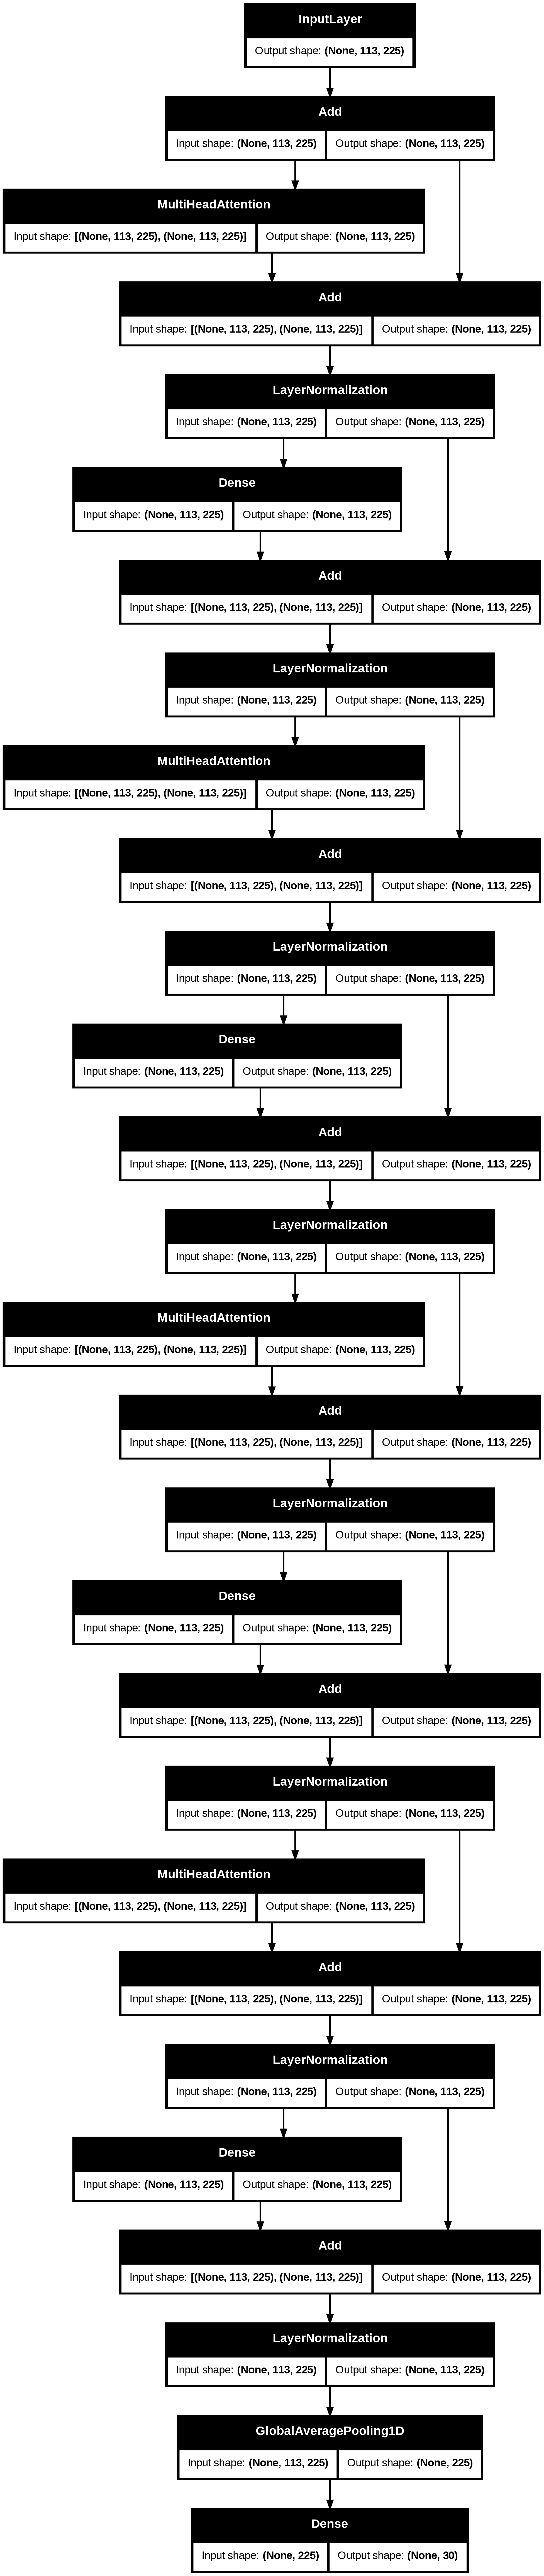

In [ ]:
!pip install -q pydot graphviz
from tensorflow.keras.utils import plot_model

# Save and display the model architecture
plot_model(transformer_model, show_shapes=True, to_file='transformer_model.png')

### Normalized X Model

In [18]:
# Instantiate the model
transformer_model = create_transformer_model(input_shape, num_classes)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 0.3017 - loss: 2.4896 - val_accuracy: 0.4833 - val_loss: 1.4086
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7540 - loss: 0.8070 - val_accuracy: 0.6167 - val_loss: 1.3091
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9327 - loss: 0.2415 - val_accuracy: 0.7333 - val_loss: 1.0491
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9747 - loss: 0.1102 - val_accuracy: 0.7000 - val_loss: 1.0145
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9828 - loss: 0.0826 - val_accuracy: 0.6667 - val_loss: 1.1403
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9875 - loss: 0.0535 - val_accuracy: 0.7667 - val_loss: 1.0259
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9929 - loss: 0.0450 - val_accuracy: 0.7500 - val_loss: 0.9956
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9996 - loss: 0.0107 - val_accuracy: 0.7333 -

### Standardized X Model

In [13]:
# Instantiate the model
transformer_model = create_transformer_model(input_shape, num_classes)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 306ms/step - accuracy: 0.3029 - loss: 2.5347 - val_accuracy: 0.5167 - val_loss: 1.3510
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7892 - loss: 0.8202 - val_accuracy: 0.7167 - val_loss: 0.9421
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9276 - loss: 0.2803 - val_accuracy: 0.6833 - val_loss: 0.9911
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9920 - loss: 0.0795 - val_accuracy: 0.7500 - val_loss: 0.8827
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9868 - loss: 0.0664 - val_accuracy: 0.7333 - val_loss: 1.0021
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9929 - loss: 0.0404 - val_accuracy: 0.8000 - val_loss: 0.8190
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.7667 - val_loss: 0.8889
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.8000 -

## Doubling the attention head amount

In [23]:
def create_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positional_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(tf.range(input_shape[0]))
    x = inputs + positional_encoding

    # Transformer Encoder
    for _ in range(4):  # Number of Transformer blocks
        # Instead of 4 (base), 8 used
        attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
        ff_output = layers.Dense(225, activation='relu')(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [24]:
transformer_model = create_transformer_model(input_shape, num_classes)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 327ms/step - accuracy: 0.3132 - loss: 2.5096 - val_accuracy: 0.4833 - val_loss: 1.4368
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7791 - loss: 0.7346 - val_accuracy: 0.6833 - val_loss: 1.0327
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9167 - loss: 0.2776 - val_accuracy: 0.7167 - val_loss: 0.8751
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9718 - loss: 0.1193 - val_accuracy: 0.8000 - val_loss: 0.9178
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9777 - loss: 0.1199 - val_accuracy: 0.7500 - val_loss: 1.0720
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9978 - loss: 0.0302 - val_accuracy: 0.8167 - val_loss: 0.8824
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.7333 - val_loss: 0.9625
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.8167 -

## Increase Feed Forward Layer

In [25]:
def create_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positional_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(tf.range(input_shape[0]))
    x = inputs + positional_encoding

    # Transformer Encoder
    for _ in range(4):  # Number of Transformer blocks
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
        # Instead of a single layer with 225 units, add 1 denser layer.
        ff_output = layers.Dense(512, activation='relu')(x)
        ff_output = layers.Dense(225, activation='relu')(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [26]:
transformer_model = create_transformer_model(input_shape, num_classes)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 384ms/step - accuracy: 0.2991 - loss: 2.6598 - val_accuracy: 0.5500 - val_loss: 1.3377
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7063 - loss: 0.9681 - val_accuracy: 0.7167 - val_loss: 0.8973
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9054 - loss: 0.3027 - val_accuracy: 0.7833 - val_loss: 0.9607
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9789 - loss: 0.0888 - val_accuracy: 0.7500 - val_loss: 0.9806
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9837 - loss: 0.0748 - val_accuracy: 0.7667 - val_loss: 0.8508
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.7667 - val_loss: 0.8695
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.7667 - val_loss: 0.8939
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.7667 -

## Pre-Normalization Layer

In [27]:
def create_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positional_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(tf.range(input_shape[0]))
    x = inputs + positional_encoding

    # Transformer Encoder
    for _ in range(4):  # Number of Transformer blocks
        # Normalized before attention, instead of after
        x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x_norm, x_norm)
        x = x + attention_output
        ff_output = layers.Dense(225, activation='relu')(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [28]:
transformer_model = create_transformer_model(input_shape, num_classes)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 324ms/step - accuracy: 0.3071 - loss: 2.4669 - val_accuracy: 0.5500 - val_loss: 1.2443
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7440 - loss: 0.8554 - val_accuracy: 0.7000 - val_loss: 0.9651
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8909 - loss: 0.3650 - val_accuracy: 0.7833 - val_loss: 0.8677
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9719 - loss: 0.1190 - val_accuracy: 0.6833 - val_loss: 1.1519
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9805 - loss: 0.0705 - val_accuracy: 0.7833 - val_loss: 0.8070
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9966 - loss: 0.0189 - val_accuracy: 0.8000 - val_loss: 0.8497
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.8500 - val_loss: 0.8405
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.8333 -

## Drop Out Layer

In [29]:
def create_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positional_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(tf.range(input_shape[0]))
    x = inputs + positional_encoding

    # Transformer Encoder
    for _ in range(4):  # Number of Transformer blocks
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
        ff_output = layers.Dense(225, activation='relu')(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    # Drop out for regularization
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [30]:
transformer_model = create_transformer_model(input_shape, num_classes)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - accuracy: 0.2723 - loss: 2.6195 - val_accuracy: 0.4667 - val_loss: 1.5579
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7099 - loss: 0.9428 - val_accuracy: 0.6333 - val_loss: 1.2354
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8712 - loss: 0.3817 - val_accuracy: 0.7167 - val_loss: 1.0123
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9598 - loss: 0.1505 - val_accuracy: 0.7667 - val_loss: 0.9083
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9911 - loss: 0.0576 - val_accuracy: 0.7667 - val_loss: 1.0791
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0248 - val_accuracy: 0.7833 - val_loss: 1.0123
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9946 - loss: 0.0174 - val_accuracy: 0.8000 - val_loss: 1.1465
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9966 - loss: 0.0125 - val_accuracy: 0.7500 -

## More Transformer Block

In [31]:
def create_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positional_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(tf.range(input_shape[0]))
    x = inputs + positional_encoding

    # Transformer Encoder
    for _ in range(8):  # Number of Transformer blocks, 8 instead of 4
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
        ff_output = layers.Dense(225, activation='relu')(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [32]:
transformer_model = create_transformer_model(input_shape, num_classes)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 489ms/step - accuracy: 0.2694 - loss: 2.7258 - val_accuracy: 0.4000 - val_loss: 1.8256
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5575 - loss: 1.3386 - val_accuracy: 0.6000 - val_loss: 1.2493
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8536 - loss: 0.4463 - val_accuracy: 0.6000 - val_loss: 1.2186
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8881 - loss: 0.3742 - val_accuracy: 0.7167 - val_loss: 1.1469
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9313 - loss: 0.2202 - val_accuracy: 0.7000 - val_loss: 1.1095
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9596 - loss: 0.1217 - val_accuracy: 0.7167 - val_loss: 1.3641
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9868 - loss: 0.0611 - val_accuracy: 0.7000 - val_loss: 1.2647
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9840 - loss: 0.0597 - val_accuracy: 0.7000 -

# Compile Variation

## AdamW Optimizer with Weight Decay

In [50]:
from tensorflow.keras.optimizers import AdamW

transformer_model = create_transformer_model(input_shape, num_classes)

# Define weight decay
weight_decay = 1e-4  # You can adjust this value (e.g., 1e-3, 5e-5)

# Update optimizer to use AdamW
optimizer = AdamW(learning_rate=0.001, weight_decay=weight_decay)

# Compile the model
transformer_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


model = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 480ms/step - accuracy: 0.2931 - loss: 2.6936 - val_accuracy: 0.4167 - val_loss: 1.5848
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6815 - loss: 0.9463 - val_accuracy: 0.6667 - val_loss: 1.0821
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8946 - loss: 0.3447 - val_accuracy: 0.7000 - val_loss: 1.3510
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9585 - loss: 0.1587 - val_accuracy: 0.6833 - val_loss: 1.0166
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9736 - loss: 0.0914 - val_accuracy: 0.7167 - val_loss: 1.3142
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9508 - loss: 0.1489 - val_accuracy: 0.6500 - val_loss: 1.3816
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9292 - loss: 0.2304 - val_accuracy: 0.5333 - val_loss: 2.0453
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8112 - loss: 0.7113 - val_accuracy: 0.6000 -

## Label Smoothing on Loss Function

In [45]:
transformer_model = create_transformer_model(input_shape, num_classes)

def smooth_labels(y_true, num_classes, smoothing=0.1):
    # Convert to one-hot
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)
    # Apply smoothing
    smoothed_labels = y_true_one_hot * (1 - smoothing) + (smoothing / num_classes)
    return smoothed_labels

# Usage in loss function
num_classes = 30
label_smoothing = 0.1
y_train_smoothed = smooth_labels(y_train, num_classes, smoothing=label_smoothing)
y_test_smoothed = smooth_labels(y_test, num_classes, smoothing=label_smoothing)

# Compile model
loss = tf.keras.losses.CategoricalCrossentropy()
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=['accuracy']
)

# Train model
model = transformer_model.fit(
    X_train, y_train_smoothed,
    validation_data=(X_test, y_test_smoothed),
    epochs=30,
    batch_size=32,
)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 475ms/step - accuracy: 0.2817 - loss: 2.8714 - val_accuracy: 0.4167 - val_loss: 2.0980
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7594 - loss: 1.3759 - val_accuracy: 0.6333 - val_loss: 1.5886
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8519 - loss: 1.1268 - val_accuracy: 0.7167 - val_loss: 1.5966
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9528 - loss: 0.8635 - val_accuracy: 0.7000 - val_loss: 1.5965
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9689 - loss: 0.8183 - val_accuracy: 0.6833 - val_loss: 1.5687
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9849 - loss: 0.7691 - val_accuracy: 0.7333 - val_loss: 1.4539
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9960 - loss: 0.7018 - val_accuracy: 0.7333 - val_loss: 1.4944
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9983 - loss: 0.6787 - val_accuracy: 0.7333 

## Learning Rate Scheduler, Reduce on Plateau

In [46]:
transformer_model = create_transformer_model(input_shape, num_classes)

# Compile the model
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Initial learning rate
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Add the learning rate scheduler callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train the model with the callback
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[lr_callback]
)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 518ms/step - accuracy: 0.3014 - loss: 2.6465 - val_accuracy: 0.5667 - val_loss: 1.6640 - learning_rate: 0.0010
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6443 - loss: 1.1664 - val_accuracy: 0.5500 - val_loss: 1.5765 - learning_rate: 0.0010
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7194 - loss: 0.8367 - val_accuracy: 0.5833 - val_loss: 1.3792 - learning_rate: 0.0010
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8999 - loss: 0.3602 - val_accuracy: 0.7000 - val_loss: 1.3522 - learning_rate: 0.0010
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9240 - loss: 0.2044 - val_accuracy: 0.6333 - val_loss: 1.3042 - learning_rate: 0.0010
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9346 - loss: 0.2725 - val_accuracy: 0.6000 - val_loss: 1.3903 - learning_rate: 0.0010
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9026 - loss: 0.3529 - val_a

# Training Variation

## Smaller Batch Size

In [52]:
transformer_model = create_transformer_model(input_shape, num_classes)

# Compile the model
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train with a custom batch size
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,      # Smaller batch size
)


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 321ms/step - accuracy: 0.2750 - loss: 2.7244 - val_accuracy: 0.2667 - val_loss: 2.5455
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.4919 - loss: 1.4700 - val_accuracy: 0.5167 - val_loss: 1.5835
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7488 - loss: 0.7318 - val_accuracy: 0.6000 - val_loss: 1.3569
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8635 - loss: 0.4024 - val_accuracy: 0.6167 - val_loss: 1.4069
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8509 - loss: 0.4558 - val_accuracy: 0.6000 - val_loss: 1.4172
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8828 - loss: 0.3595 - val_accuracy: 0.6500 - val_loss: 1.3454
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9417 - loss: 0.1866 - val_accuracy: 0.7333 - val_loss: 0.7801
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9255 - loss: 0.2863 - val_accuracy: 0.6167

In [14]:
transformer_model = create_transformer_model(input_shape, num_classes)

# Compile the model
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train with a custom batch size
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,      # Smaller batch size
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - accuracy: 0.3137 - loss: 2.5163 - val_accuracy: 0.5833 - val_loss: 1.3949
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7534 - loss: 0.7118 - val_accuracy: 0.5500 - val_loss: 1.2435
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8660 - loss: 0.4255 - val_accuracy: 0.6500 - val_loss: 0.9408
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9632 - loss: 0.1208 - val_accuracy: 0.7500 - val_loss: 1.0297
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9914 - loss: 0.0436 - val_accuracy: 0.6833 - val_loss: 1.0585
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9879 - loss: 0.0543 - val_accuracy: 0.6833 - val_loss: 1.0230
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9864 - loss: 0.0583 - val_accuracy: 0.6000 - val_loss: 1.4931
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8798 - loss: 0.4125 - val_accuracy: 0.5000 -

## Early Stopping

In [13]:
transformer_model = create_transformer_model(input_shape, num_classes)

# Compile the model
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train with a custom batch size
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,          # Max epochs
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 333ms/step - accuracy: 0.3180 - loss: 2.4545 - val_accuracy: 0.5167 - val_loss: 1.3788
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7700 - loss: 0.7880 - val_accuracy: 0.7000 - val_loss: 1.0450
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9190 - loss: 0.2869 - val_accuracy: 0.6833 - val_loss: 0.9669
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9791 - loss: 0.1087 - val_accuracy: 0.7000 - val_loss: 0.9517
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9870 - loss: 0.0492 - val_accuracy: 0.7833 - val_loss: 0.9489
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9938 - loss: 0.0252 - val_accuracy: 0.7500 - val_loss: 0.9623
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 0.7833 - val_loss: 0.9599
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.7833 -

# Future Improvement Plan


1.   Explore feature engineering, including geometric and/or temporal features such as angles and velocities.
2.   Identify the "best" variations and use them to build a new model.
3. Perform hyperparameter tuning using Keras Tuner.



In [ ]:
!pip install -q dagshub

from dagshub.notebook import save_notebook

save_notebook(repo="Omdena/JakartaIndonesia_SignLanguageTranslation", path="modeling", branch="kenji")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.3 MB/s eta 0:00:00
